# Relegation Probability Conditional on League Points Tuples

In [29]:
import numpy as np
from dataclasses import dataclass
from itertools import permutations
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from typing import Iterable, Tuple, Dict, List, Optional, Set

In [30]:
# Kick Rate
kickrate_npz_path = r"C:\Users\olwyn\OneDrive\Desktop\Working Models\Promotion Probability\teamSeasonKickrate.npz"
with np.load(kickrate_npz_path, allow_pickle=True) as z:
    team_season_keys = z["team_season_keys"]
    team_season_vals = z["team_season_vals"]
team_season_to_kickrate = dict(zip(map(str, team_season_keys), team_season_vals.astype(float)))

# Weibull parameters
weibull_npz_path = r"C:\Users\olwyn\OneDrive\Desktop\Working Models\Promotion Probability\weibullParams.npz"
with np.load(weibull_npz_path, allow_pickle=True) as z:
    alpha_try   = float(z["alpha_try"])
    alpha_goal  = float(z["alpha_goal"])
    lam         = z["lam"].astype(float)
    gamma_try   = float(z["gamma_try"])
    gamma_goal  = float(z["gamma_goal"])

    A_try   = z["A_try"].astype(float)
    D_try   = z["D_try"].astype(float)
    A_goal  = z["A_goal"].astype(float)
    D_goal  = z["D_goal"].astype(float)

    beta_try  = z["beta_try"].astype(float)
    beta_goal = z["beta_goal"].astype(float)

    team_names = np.array([str(t) for t in z["team_names"]], dtype=object)
    n_teams    = int(z["n_teams"])

params_hat = {
    "alpha_try": alpha_try,
    "alpha_goal": alpha_goal,
    "lam": lam,
    "gamma_try": gamma_try,
    "gamma_goal": gamma_goal,
    "A_try": A_try,
    "D_try": D_try,
    "A_goal": A_goal,
    "D_goal": D_goal,
    "beta_try": beta_try,
    "beta_goal": beta_goal,
}

In [31]:
SEASON_TAG = "_2425"

full_team_names = np.array([str(t) for t in team_names], dtype=object)

idx_2425 = np.array(
    [i for i, t in enumerate(full_team_names) if t.endswith(SEASON_TAG)],
    dtype=np.int32
)

team_names_2425 = full_team_names[idx_2425].tolist()

team_to_idx = {team: i for i, team in enumerate(team_names_2425)}
idx_to_team = {i: team for team, i in team_to_idx.items()}
n_teams_2425 = len(team_names_2425)

# Slice team-effect arrays
A_try_2425  = A_try[idx_2425]
D_try_2425  = D_try[idx_2425]
A_goal_2425 = A_goal[idx_2425]
D_goal_2425 = D_goal[idx_2425]

# Rebuild params_hat with sliced arrays
params_hat = {
    "alpha_try": alpha_try,
    "alpha_goal": alpha_goal,
    "lam": lam,
    "gamma_try": gamma_try,
    "gamma_goal": gamma_goal,
    "A_try": A_try_2425,
    "D_try": D_try_2425,
    "A_goal": A_goal_2425,
    "D_goal": D_goal_2425,
    "beta_try": beta_try,
    "beta_goal": beta_goal,
}


In [32]:
league_table_2425_RD15 = {
    "Old Belvedere_2425": {"PTS": 69, "DIFF": 273},                  # +6 diff reversed
    "Nenagh Ormond_2425": {"PTS": 53, "DIFF": 74},                   # -4 LP, -8 diff
    "Blackrock College RFC_2425": {"PTS": 47, "DIFF": 49},           # -4 LP, -6 diff
    "University College Cork_2425": {"PTS": 39, "DIFF": 32},         # -4 LP, -1 diff
    "Old Wesley_2425": {"PTS": 45, "DIFF": 58},                      # +8 diff reversed
    "Queens University Belfast RFC_2425": {"PTS": 38, "DIFF": -97},  # +1 diff reversed
    "Naas_2425": {"PTS": 37, "DIFF": 2},                             # +5 diff reversed
    "Highfield_2425": {"PTS": 25, "DIFF": -141},                     # -4 LP, -5 diff
    "Dublin University_2425": {"PTS": 29, "DIFF": -121},             # +5 diff reversed
    "Shannon_2425": {"PTS": 20, "DIFF": -109},                   # -4 LP, -5 diff
}
league_table_2425_RD16 = {
    "Old Belvedere_2425": {"PTS": 69, "DIFF": 267},                  # -5 LP, -18 diff
    "Nenagh Ormond_2425": {"PTS": 57, "DIFF": 82},                   # -4 LP, -4 diff
    "Blackrock College RFC_2425": {"PTS": 51, "DIFF": 55},           # -0 LP, +4 diff
    "University College Cork_2425": {"PTS": 43, "DIFF": 33},         # -5 LP, -38 diff
    "Old Wesley_2425": {"PTS": 45, "DIFF": 50},                      # -5 LP, -29 diff
    "Queens University Belfast RFC_2425": {"PTS": 38, "DIFF": -98},  # -4 LP, -11 diff
    "Naas_2425": {"PTS": 37, "DIFF": -3},                            # -0 LP, +11 diff
    "Highfield_2425": {"PTS": 29, "DIFF": -146},                     # -0 LP, +38 diff
    "Dublin University_2425": {"PTS": 29, "DIFF": -126},             # -0 LP, +18 diff
    "Shannon_2425": {"PTS": 24, "DIFF": -114},                   # -0 LP, +29 diff
}
league_table_2425_RD17 = {
    "Old Belvedere_2425": {"PTS": 74, "DIFF": 285},                    # reversed F5 (lost by 33, got 0 LP)
    "Nenagh Ormond_2425": {"PTS": 61, "DIFF": 86},                     # reversed F2 (lost by 13, got 0 LP)
    "Blackrock College RFC_2425": {"PTS": 51, "DIFF": 51},             # reversed F1 (won by 12, got 5 LP)
    "University College Cork_2425": {"PTS": 48, "DIFF": 71},           # reversed F5 (won by 33, got 5 LP)
    "Old Wesley_2425": {"PTS": 50, "DIFF": 79},                        # reversed F1 (lost by 12, got 1 LP)
    "Queens University Belfast RFC_2425": {"PTS": 42, "DIFF": -87},    # reversed F4 (lost by 54, got 0 LP)
    "Naas_2425": {"PTS": 37, "DIFF": -14},                             # reversed F3 (lost by 1, got 2 LP)
    "Highfield_2425": {"PTS": 29, "DIFF": -184},                       # reversed F3 (won by 1, got 5 LP)
    "Dublin University_2425": {"PTS": 29, "DIFF": -144},               # reversed F2 (won by 13, got 4 LP)
    "Shannon_2425": {"PTS": 24, "DIFF": -143},                     # reversed F4 (won by 54, got 5 LP)
}

In [33]:
fixtures_remaining_after_15 = [
    # RD16 (Sat 22 Mar)
    ("Blackrock College RFC_2425", "Old Belvedere_2425"),
    ("Dublin University_2425", "Highfield_2425"),
    ("Naas_2425", "Shannon_2425"),
    ("Nenagh Ormond_2425", "Old Wesley_2425"),
    ("University College Cork_2425", "Queens University Belfast RFC_2425"),

    # RD17 (Sat 29 Mar)
    ("Highfield_2425", "University College Cork_2425"),
    ("Nenagh Ormond_2425", "Blackrock College RFC_2425"),
    ("Old Belvedere_2425", "Dublin University_2425"),
    ("Old Wesley_2425", "Shannon_2425"),
    ("Queens University Belfast RFC_2425", "Naas_2425"),

    # RD18 / Final round (Sat 5 Apr)
    ("Blackrock College RFC_2425", "Old Wesley_2425"),
    ("Dublin University_2425", "Nenagh Ormond_2425"),
    ("Naas_2425", "Highfield_2425"),
    ("Shannon_2425", "Queens University Belfast RFC_2425"),
    ("University College Cork_2425", "Old Belvedere_2425"),
]
fixtures_remaining_after_16 = [
    # RD17 (Sat 29 Mar)
    ("Highfield_2425", "University College Cork_2425"),
    ("Nenagh Ormond_2425", "Blackrock College RFC_2425"),
    ("Old Belvedere_2425", "Dublin University_2425"),
    ("Old Wesley_2425", "Shannon_2425"),
    ("Queens University Belfast RFC_2425", "Naas_2425"),

    # RD18 / Final round (Sat 5 Apr)
    ("Blackrock College RFC_2425", "Old Wesley_2425"),
    ("Dublin University_2425", "Nenagh Ormond_2425"),
    ("Naas_2425", "Highfield_2425"),
    ("Shannon_2425", "Queens University Belfast RFC_2425"),
    ("University College Cork_2425", "Old Belvedere_2425"),
]
fixtures_remaining_after_17 = [
    # RD18 / Final round (Sat 5 Apr)
    ("Blackrock College RFC_2425", "Old Wesley_2425"),
    ("Dublin University_2425", "Nenagh Ormond_2425"),
    ("Naas_2425", "Highfield_2425"),
    ("Shannon_2425", "Queens University Belfast RFC_2425"),
    ("University College Cork_2425", "Old Belvedere_2425"),
]

Single Game Simulator

In [34]:
PTS_TRY  = 5
PTS_CONV = 2
PTS_GOAL = 3  
HAZ_ORDER = ["home_try", "away_try", "home_goal", "away_goal"]
R = 81
MARGIN_MIN = -40
MARGIN_MAX = 40

def _clip_margin_to_idx(margin: float) -> int:
    m = int(round(margin))
    if m < MARGIN_MIN:
        m = MARGIN_MIN
    elif m > MARGIN_MAX:
        m = MARGIN_MAX
    return m - MARGIN_MIN
def compute_league_points(
    home_pts: np.ndarray,
    away_pts: np.ndarray,
    home_tries: np.ndarray,
    away_tries: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Rules:
      - Win=4, Draw=2, Loss=0
      - +1 for losing by <=7
      - +1 for scoring >=4 tries
    """
    home_pts = np.asarray(home_pts)
    away_pts = np.asarray(away_pts)
    home_tries = np.asarray(home_tries)
    away_tries = np.asarray(away_tries)

    home_win = home_pts > away_pts
    away_win = away_pts > home_pts
    draw = home_pts == away_pts

    lp_home = np.zeros_like(home_pts, dtype=np.int32)
    lp_away = np.zeros_like(away_pts, dtype=np.int32)

    lp_home[home_win] = 4
    lp_away[away_win] = 4
    lp_home[draw] = 2
    lp_away[draw] = 2

    margin = np.abs(home_pts - away_pts)
    lp_home[(away_win) & (margin <= 7)] += 1
    lp_away[(home_win) & (margin <= 7)] += 1

    lp_home[home_tries >= 4] += 1
    lp_away[away_tries >= 4] += 1

    return lp_home, lp_away
def _draw_weibull_residual_time(alpha: float, rate: float, rng: np.random.Generator, age: float) -> float:
    """
    Residual time until event for a Weibull process with shape alpha and 'rate' parameterization
    consistent with your existing code, conditional on having already survived `age` minutes.

    If age=0, this reduces to your usual draw.
    """
    rate = float(max(rate, 1e-12))
    age = float(max(age, 0.0))
    E = float(rng.exponential(1.0))
    return (age**alpha + E / rate) ** (1.0 / alpha) - age
def _get_conv_rate(team_season: str, team_season_to_kickrate: dict, *, default: float = 0.72) -> float:
    """
    Return the conversion success probability for a given team-season.

    If not found, fall back to:
      - season-average (if we can compute it), else
      - `default`.

    Notes:
      - team_season is like "Dublin University_2526"
      - team_season_to_kickrate maps str -> float
    """
    if team_season in team_season_to_kickrate:
        p = float(team_season_to_kickrate[team_season])
        return float(np.clip(p, 0.01, 0.99))

    # fallback: season average for that season tag (e.g. "_2526")
    season_tag = "_" + team_season.split("_")[-1]  # "_2526"
    vals = [float(v) for k, v in team_season_to_kickrate.items() if str(k).endswith(season_tag)]
    if len(vals) > 0:
        p = float(np.mean(vals))
        return float(np.clip(p, 0.01, 0.99))

    return float(np.clip(default, 0.01, 0.99))
def simulate_one_match(
    params: dict,
    home_u: int,
    away_u: int,
    home_team_season: str,
    away_team_season: str,
    team_season_to_kickrate: dict,
    rng: np.random.Generator,
    end_time: float = 80.0,
    # -------- new: in-game state ----------
    t0: float = 0.0,
    home_pts0: int = 0,
    away_pts0: int = 0,
    home_tries0: int = 0,
    away_tries0: int = 0,
    last_hazard_time: float | None = None,  # minutes; if None, assume fresh spell at t0
) -> tuple[int, int, int, int]:
    """
    Returns: (home_pts, away_pts, home_tries, away_tries)

    In-game usage:
      - set t0 to current time (mins)
      - set score/tries to current values
      - set last_hazard_time to the minute of the last scoring event (spell reset)
        (then spell age = t0 - last_hazard_time)

    Notes:
      - Half-time/full-time boundaries: your existing censoring logic is preserved.
      - After any scoring event occurs in simulation, spell age resets to 0 (last_hazard_time = t).
    """
    alpha_try = float(params["alpha_try"])
    alpha_goal = float(params["alpha_goal"])
    lam = np.asarray(params["lam"], dtype=float)  # [HT, AT, HG, AG]
    gamma_try = float(params["gamma_try"])
    gamma_goal = float(params["gamma_goal"])

    A_try = np.asarray(params["A_try"], dtype=float)
    D_try = np.asarray(params["D_try"], dtype=float)
    A_goal = np.asarray(params["A_goal"], dtype=float)
    D_goal = np.asarray(params["D_goal"], dtype=float)

    beta_try = np.asarray(params["beta_try"], dtype=float)    # length 81
    beta_goal = np.asarray(params["beta_goal"], dtype=float)  # length 81

    p_conv_home = _get_conv_rate(home_team_season, team_season_to_kickrate)
    p_conv_away = _get_conv_rate(away_team_season, team_season_to_kickrate)

    # ---------- initialize state ----------
    t = float(t0)
    home_pts = int(home_pts0)
    away_pts = int(away_pts0)
    home_tries = int(home_tries0)
    away_tries = int(away_tries0)
    margin = home_pts - away_pts

    # if last_hazard_time not provided, assume spell just started at t0
    if last_hazard_time is None:
        last_hazard_time = t
    last_hazard_time = float(last_hazard_time)

    while t < end_time - 1e-9:
        next_boundary = 40.0 if t < 40.0 else 80.0
        dt_max = next_boundary - t
        if dt_max <= 1e-9:
            t = next_boundary
            # treat boundary as a restart point (new spell)
            last_hazard_time = t
            continue

        # current spell age (mins since last scoring event / restart)
        age = max(0.0, t - last_hazard_time)

        idx_home = _clip_margin_to_idx(margin)
        idx_away = (R - 1) - idx_home

        f_try_home = beta_try[idx_home]
        f_try_away = beta_try[idx_away]
        f_goal_home = beta_goal[idx_home]
        f_goal_away = beta_goal[idx_away]

        eta_HT = gamma_try + (A_try[home_u] - D_try[away_u]) + f_try_home
        eta_AT = -gamma_try + (A_try[away_u] - D_try[home_u]) + f_try_away
        eta_HG = gamma_goal + (A_goal[home_u] - D_goal[away_u]) + f_goal_home
        eta_AG = -gamma_goal + (A_goal[away_u] - D_goal[home_u]) + f_goal_away

        rate_HT = lam[0] * np.exp(eta_HT)
        rate_AT = lam[1] * np.exp(eta_AT)
        rate_HG = lam[2] * np.exp(eta_HG)
        rate_AG = lam[3] * np.exp(eta_AG)

        # residual draws conditional on surviving `age` minutes in the current spell
        T_HT = _draw_weibull_residual_time(alpha_try,  rate_HT, rng, age)
        T_AT = _draw_weibull_residual_time(alpha_try,  rate_AT, rng, age)
        T_HG = _draw_weibull_residual_time(alpha_goal, rate_HG, rng, age)
        T_AG = _draw_weibull_residual_time(alpha_goal, rate_AG, rng, age)

        Ts = np.array([T_HT, T_AT, T_HG, T_AG], dtype=float)
        k = int(np.argmin(Ts))
        dt = float(Ts[k])

        # censor to boundary
        if dt >= dt_max:
            t = next_boundary
            last_hazard_time = t  # boundary restart
            continue

        # event occurs
        t = t + dt
        ev = HAZ_ORDER[k]

        if ev == "home_try":
            home_pts += PTS_TRY
            home_tries += 1
            if rng.random() < p_conv_home:
                home_pts += PTS_CONV

        elif ev == "away_try":
            away_pts += PTS_TRY
            away_tries += 1
            if rng.random() < p_conv_away:
                away_pts += PTS_CONV

        elif ev == "home_goal":
            home_pts += PTS_GOAL

        elif ev == "away_goal":
            away_pts += PTS_GOAL

        margin = home_pts - away_pts

        # restart spell clock after a scoring event
        last_hazard_time = t

    return home_pts, away_pts, home_tries, away_tries

Teams Sorted

In [35]:
teams_sorted = sorted(league_table_2425_RD15.keys())
team_to_idx = {team: i for i, team in enumerate(teams_sorted)}

Pregame Simulations

In [36]:
def simulate_rest_of_season_excluding_block(
    *,
    teams_sorted: list[str],
    league_table: dict,
    remaining_fixtures: list[tuple[str, str]],
    drop_first_n_fixtures: int,
    exclude_fixture: tuple[str, str] | None,
    params_hat: dict,
    team_to_idx: dict,
    team_season_to_kickrate: dict,
    n_sims: int = 200,
    seed: int = 7,
    end_time: float = 80.0,
) -> tuple[list[str], np.ndarray, np.ndarray]:
    """
    Simulate the rest of season AFTER dropping the first N fixtures (i.e. for round 16/17 pregame logic),
    optionally excluding one fixture (your DU fixture), returning (teams_sorted, pts_sim, diff_sim).

    Relegation notebook adjustment:
    - If there are NO fixtures remaining (e.g. round 18 pregame), return constant arrays equal to current table.
    """
    rng = np.random.default_rng(seed)
    n_teams = len(teams_sorted)

    pts0 = np.array([league_table[t]["PTS"] for t in teams_sorted], dtype=np.int32)
    diff0 = np.array([league_table[t]["DIFF"] for t in teams_sorted], dtype=np.int32)

    fixtures = remaining_fixtures[drop_first_n_fixtures:]

    def _same_fixture(a: tuple[str, str], b: tuple[str, str]) -> bool:
        return (a[0] == b[0] and a[1] == b[1]) or (a[0] == b[1] and a[1] == b[0])

    if exclude_fixture is not None:
        fixtures = [fx for fx in fixtures if not _same_fixture(fx, exclude_fixture)]

    # --- NEW: handle "no fixtures remaining" cleanly (round 18 pregame) ---
    if len(fixtures) == 0:
        pts_sim = np.repeat(pts0[None, :], n_sims, axis=0).astype(np.int32, copy=False)
        diff_sim = np.repeat(diff0[None, :], n_sims, axis=0).astype(np.int32, copy=False)
        return teams_sorted, pts_sim, diff_sim

    pts_sim = np.empty((n_sims, n_teams), dtype=np.int32)
    diff_sim = np.empty((n_sims, n_teams), dtype=np.int32)

    for s in range(n_sims):
        pts_row = pts0.copy()
        diff_row = diff0.copy()

        for home, away in fixtures:
            hu = int(team_to_idx[home])
            au = int(team_to_idx[away])

            hp, ap, ht, at = simulate_one_match(
                params_hat,
                hu,
                au,
                home,
                away,
                team_season_to_kickrate,
                rng,
                end_time=end_time,
                t0=0.0,
                home_pts0=0,
                away_pts0=0,
                home_tries0=0,
                away_tries0=0,
                last_hazard_time=0.0,
            )

            lp_h, lp_a = compute_league_points(
                np.array([hp], dtype=np.int32),
                np.array([ap], dtype=np.int32),
                np.array([ht], dtype=np.int32),
                np.array([at], dtype=np.int32),
            )
            lp_h = int(lp_h[0])
            lp_a = int(lp_a[0])

            hi = int(team_to_idx[home])
            ai = int(team_to_idx[away])

            pts_row[hi] += lp_h
            pts_row[ai] += lp_a

            d = int(hp) - int(ap)
            diff_row[hi] += d
            diff_row[ai] -= d

        pts_sim[s] = pts_row
        diff_sim[s] = diff_row

    return teams_sorted, pts_sim, diff_sim
def simulate_inplay_4games_additive(
    *,
    games: list[tuple[str, str]],
    home_scores: list[int],
    home_tries: list[int],
    away_scores: list[int],
    away_tries: list[int],
    game_times: list[float],
    game_LH: list[float],
    params_hat: dict,
    team_to_idx: dict,
    team_season_to_kickrate: dict,
    n_sims: int = 200,
    seed: int = 11,
    end_time: float = 80.0,
) -> tuple[np.ndarray, np.ndarray]:
    if not (len(games) == len(home_scores) == len(home_tries) == len(away_scores) == len(away_tries) == len(game_times) == len(game_LH) == 4):
        raise ValueError("All per-game lists must be length 4.")

    rng = np.random.default_rng(seed)
    n_teams = len(team_to_idx)

    pts_add = np.zeros((n_sims, n_teams), dtype=np.int32)
    diff_add = np.zeros((n_sims, n_teams), dtype=np.int32)

    for s in range(n_sims):
        for g in range(4):
            home, away = games[g]
            hu = int(team_to_idx[home])
            au = int(team_to_idx[away])

            hp, ap, ht, at = simulate_one_match(
                params_hat,
                hu,
                au,
                home,
                away,
                team_season_to_kickrate,
                rng,
                end_time=end_time,
                t0=float(game_times[g]),
                home_pts0=int(home_scores[g]),
                away_pts0=int(away_scores[g]),
                home_tries0=int(home_tries[g]),
                away_tries0=int(away_tries[g]),
                last_hazard_time=float(game_LH[g]),
            )

            lp_h, lp_a = compute_league_points(
                np.array([hp], dtype=np.int32),
                np.array([ap], dtype=np.int32),
                np.array([ht], dtype=np.int32),
                np.array([at], dtype=np.int32),
            )
            lp_h = int(lp_h[0])
            lp_a = int(lp_a[0])

            pts_add[s, hu] += lp_h
            pts_add[s, au] += lp_a

            d = int(hp) - int(ap)
            diff_add[s, hu] += d
            diff_add[s, au] -= d

    return pts_add, diff_add
def splice_inplay_into_future(
    *,
    future_bundle: tuple[list[str], np.ndarray, np.ndarray],
    games: list[tuple[str, str]],
    home_scores: list[int],
    home_tries: list[int],
    away_scores: list[int],
    away_tries: list[int],
    game_times: list[float],
    game_LH: list[float],
    params_hat: dict,
    team_to_idx: dict,
    team_season_to_kickrate: dict,
    n_sims: int,
    seed_inplay: int = 11,
    end_time: float = 80.0,
) -> tuple[list[str], np.ndarray, np.ndarray]:
    """
    Take a pregame future sim bundle (without current round fixtures),
    simulate the other 4 in-play fixtures additively, and return base tables
    for evaluating DU's forced LP tuples (since DU fixture is excluded).
    """
    teams_sorted, pts_future_sim, diff_future_sim = future_bundle
    pts_future_sim = np.asarray(pts_future_sim)
    diff_future_sim = np.asarray(diff_future_sim)

    if pts_future_sim.shape != diff_future_sim.shape:
        raise ValueError("pts_future_sim and diff_future_sim must have same shape")
    if pts_future_sim.shape[0] != n_sims:
        raise ValueError(f"n_sims={n_sims} but future arrays have {pts_future_sim.shape[0]} sims")

    pts_add, diff_add = simulate_inplay_4games_additive(
        games=games,
        home_scores=home_scores,
        home_tries=home_tries,
        away_scores=away_scores,
        away_tries=away_tries,
        game_times=game_times,
        game_LH=game_LH,
        params_hat=params_hat,
        team_to_idx=team_to_idx,
        team_season_to_kickrate=team_season_to_kickrate,
        n_sims=n_sims,
        seed=seed_inplay,
        end_time=end_time,
    )

    pts_base = pts_future_sim + pts_add
    diff_base = diff_future_sim + diff_add

    return teams_sorted, pts_base, diff_base

Remaing Fixtures (Excluding Current Block) Simulations)

In [37]:
N_SIMS_BASE = 5000
SEED_BASE = 9
OUR_MATCH_RD16 = ("Dublin University_2425", "Highfield_2425")
future_bundle_RD16_pregame = simulate_rest_of_season_excluding_block(
    teams_sorted=teams_sorted,
    league_table=league_table_2425_RD15,
    remaining_fixtures=fixtures_remaining_after_15,
    drop_first_n_fixtures=0,
    exclude_fixture=OUR_MATCH_RD16,
    params_hat=params_hat,
    team_to_idx=team_to_idx,
    team_season_to_kickrate=team_season_to_kickrate,
    n_sims=N_SIMS_BASE,
    seed=SEED_BASE,
    end_time=80.0,
)
teams_RD16, pts_RD16_future, diff_RD16_future = future_bundle_RD16_pregame


In [38]:
OUR_MATCH_RD17 = ("Old Belvedere_2425", "Dublin University_2425")
future_bundle_RD17_pregame = simulate_rest_of_season_excluding_block(
    teams_sorted=teams_sorted,
    league_table=league_table_2425_RD16,
    remaining_fixtures=fixtures_remaining_after_16,
    drop_first_n_fixtures=0,
    exclude_fixture=OUR_MATCH_RD17,
    params_hat=params_hat,
    team_to_idx=team_to_idx,
    team_season_to_kickrate=team_season_to_kickrate,
    n_sims=N_SIMS_BASE,
    seed=SEED_BASE,
    end_time=80.0,
)
teams_RD17, pts_RD17_future, diff_RD17_future = future_bundle_RD17_pregame

In [39]:
OUR_MATCH_RD18 = ("Dublin University_2425", "Nenagh Ormond_2425")
future_bundle_RD18_pregame = simulate_rest_of_season_excluding_block(
    teams_sorted=teams_sorted,
    league_table=league_table_2425_RD17,
    remaining_fixtures=fixtures_remaining_after_17,
    drop_first_n_fixtures=0,
    exclude_fixture=OUR_MATCH_RD18,
    params_hat=params_hat,
    team_to_idx=team_to_idx,
    team_season_to_kickrate=team_season_to_kickrate,
    n_sims=N_SIMS_BASE,
    seed=SEED_BASE,
    end_time=80.0,
)
teams_RD18, pts_RD18_future, diff_RD18_future = future_bundle_RD18_pregame

In [40]:
ALLOWED_LP_TUPLES = [
    (5, 0), (5, 1), (5, 2),
    (4, 0), (4, 1), (4, 2),
    (3, 2), (3, 3),
    (2, 2), (2, 3), (2, 4), (2, 5),
    (1, 4), (1, 5),
    (0, 4), (0, 5),
]
def lp_tuple_to_diff_proxy(lp_du: int, lp_opp: int) -> int:
    if lp_du > lp_opp:
        return 12 if lp_opp == 0 else 5
    if lp_du < lp_opp:
        return -12 if lp_du == 0 else -5
    return 0
def releg_prob_by_lp_tuple(
    *,
    teams_sorted: list[str],
    pts_base: np.ndarray,
    diff_base: np.ndarray,
    our_match: tuple[str, str],
    du_team: str,
    allowed_lp_tuples: list[tuple[int, int]],
    seed_ties: int = 123,
    p_rel_given_9: float = 0.5,
    p_rel_given_10: float = 1.0,
) -> pd.DataFrame:
    """
    For each forced LP tuple on DU fixture, compute:
      P(relegation) = P(finish 10th)*1 + P(finish 9th)*p_rel_given_9
    using coinflips to break any (PTS, DIFF) ties.
    """
    rng = np.random.default_rng(seed_ties)
    teams = np.asarray(teams_sorted, dtype=object)

    du_idx = int(team_to_idx[du_team])
    home, away = our_match
    if du_team not in our_match:
        raise ValueError("our_match must include du_team.")
    opp_team = away if home == du_team else home
    opp_idx = int(team_to_idx[opp_team])

    out = []
    for lp_du, lp_opp in allowed_lp_tuples:
        pts_adj = pts_base.copy()
        diff_adj = diff_base.copy()

        pts_adj[:, du_idx] += int(lp_du)
        pts_adj[:, opp_idx] += int(lp_opp)

        dproxy = int(lp_tuple_to_diff_proxy(int(lp_du), int(lp_opp)))
        diff_adj[:, du_idx] += dproxy
        diff_adj[:, opp_idx] -= dproxy

        rel = np.zeros(pts_adj.shape[0], dtype=float)

        for s in range(pts_adj.shape[0]):
            order = rank_teams_coinflip(pts_adj[s], diff_adj[s], rng)
            du_pos = int(np.where(order == du_idx)[0][0]) + 1  # 1=best ... 10=worst

            if du_pos == 10:
                rel[s] = float(p_rel_given_10)
            elif du_pos == 9:
                rel[s] = float(p_rel_given_9)
            else:
                rel[s] = 0.0

        out.append({
            "lp_du": int(lp_du),
            "lp_opp": int(lp_opp),
            "releg_prob": float(rel.mean()),
            "p_9th": float((rel == p_rel_given_9).mean()) if p_rel_given_9 not in (0.0, 1.0) else float((np.array([0]) == 1).mean()),  # placeholder (see note below)
            "p_10th": float((rel == p_rel_given_10).mean()) if p_rel_given_10 != p_rel_given_9 else float((np.array([0]) == 1).mean()),     # placeholder
        })

    df = pd.DataFrame(out).sort_values(["lp_du", "lp_opp"], ascending=[False, True]).reset_index(drop=True)

    # --- replace the placeholder p_9th/p_10th with true values computed from positions (cleanly) ---
    # We recompute quickly without changing results:
    p9_list, p10_list = [], []
    for row in df.itertuples(index=False):
        lp_du, lp_opp = int(row.lp_du), int(row.lp_opp)

        pts_adj = pts_base.copy()
        diff_adj = diff_base.copy()
        pts_adj[:, du_idx] += lp_du
        pts_adj[:, opp_idx] += lp_opp
        dproxy = int(lp_tuple_to_diff_proxy(lp_du, lp_opp))
        diff_adj[:, du_idx] += dproxy
        diff_adj[:, opp_idx] -= dproxy

        du_pos_all = np.empty(pts_adj.shape[0], dtype=np.int32)
        for s in range(pts_adj.shape[0]):
            order = rank_teams_coinflip(pts_adj[s], diff_adj[s], rng)
            du_pos_all[s] = int(np.where(order == du_idx)[0][0]) + 1

        p9_list.append(float(np.mean(du_pos_all == 9)))
        p10_list.append(float(np.mean(du_pos_all == 10)))

    df["p_9th"] = p9_list
    df["p_10th"] = p10_list

    return df
def rank_teams_coinflip(pts: np.ndarray, diff: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    pts = np.asarray(pts)
    diff = np.asarray(diff)
    n = pts.size
    order = np.lexsort((-diff, -pts))  # already best-to-worst because of negatives
    i = 0
    while i < n:
        j = i + 1
        while j < n and pts[order[j]] == pts[order[i]] and diff[order[j]] == diff[order[i]]:
            j += 1
        if j - i > 1:
            block = order[i:j].copy()
            rng.shuffle(block)
            order[i:j] = block
        i = j
    return order
def plot_lp_heatmap_pretty(
    res_df: pd.DataFrame,
    *,
    games: list[tuple[str, str]],
    home_scores: list[int],
    away_scores: list[int],
    home_tries: list[int],
    away_tries: list[int],
    game_times: list[float],
    baseline_prob: float | None = None,
    title: str = "Dublin University relegation probability (%) by forced league-points tuple",
    home_label: str = "Opponent league points",
    away_label: str = "Dublin University league points",
):
    """
    Heatmap for relegation notebook.

    Expects res_df to have columns: ['lp_du','lp_opp','releg_prob'] where releg_prob is in [0,1].
    """
    # ---- grid ----
    grid = np.full((6, 6), np.nan, dtype=float)
    for r in res_df.itertuples(index=False):
        grid[int(r.lp_du), int(r.lp_opp)] = 100.0 * float(r.releg_prob)

    vals = grid[np.isfinite(grid)]
    vmin = float(np.nanmin(vals))
    vmax = float(np.nanmax(vals))
    center = 100.0 * float(baseline_prob) if baseline_prob is not None else float(np.nanmedian(vals))
    if center <= vmin: vmin = center - 1e-6
    if center >= vmax: vmax = center + 1e-6

    # ---- nicer diverging palette + norm ----
    cmap = LinearSegmentedColormap.from_list("rwg", ["#1a9850", "#ffffff", "#d73027"], N=256)
    norm = TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)

    # ---- figure ----
    fig = plt.figure(figsize=(12.2, 6.8))
    gs = fig.add_gridspec(1, 2, width_ratios=[3.25, 1.55], wspace=0.25)

    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(grid, origin="lower", cmap=cmap, norm=norm)

    ax.set_xticks(range(6))
    ax.set_yticks(range(6))
    ax.set_xlabel(home_label, fontsize=11)
    ax.set_ylabel(away_label, fontsize=11)
    ax.set_title(title, fontsize=13, pad=10)

    # subtle gridlines
    ax.set_xticks(np.arange(-.5, 6, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 6, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.5, alpha=0.25)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.tick_params(labelsize=10)

    # numbers inside cells
    for y in range(6):
        for x in range(6):
            if np.isfinite(grid[y, x]):
                ax.text(x, y, f"{grid[y, x]:.1f}", ha="center", va="center",
                        fontsize=10, fontweight="semibold")

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Relegation probability (%)", fontsize=10)
    cbar.ax.tick_params(labelsize=9)
    if baseline_prob is not None:
        cbar.ax.axhline(center, linewidth=1)

    # ---- right panel: other games ----
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis("off")
    ax2.set_title("Other games in play", fontsize=12, pad=10)

    def pretty_name(t: str) -> str:
        # strip season suffixes
        return (
            t.replace("_2425", "")
             .replace("_2526", "")
             .replace(" RFC", "")
        )

    def fmt_time(m: float) -> str:
        m = float(m)
        return f"{int(round(m)):02d}'"

    lines = []
    for (home, away), hs, ht, a_s, a_t, tm in zip(
        games, home_scores, home_tries, away_scores, away_tries, game_times
    ):
        lines.append(f"{pretty_name(home)} vs {pretty_name(away)}")
        lines.append(f"{fmt_time(tm)}   {hs} ({ht})  –  {a_s} ({a_t})")
        lines.append("")

    ax2.text(
        0.0, 1.0,
        "\n".join(lines).strip(),
        va="top", ha="left",
        fontsize=10.5,
        family="DejaVu Sans",
        linespacing=1.25
    )

    plt.show()

In Game

Round 16

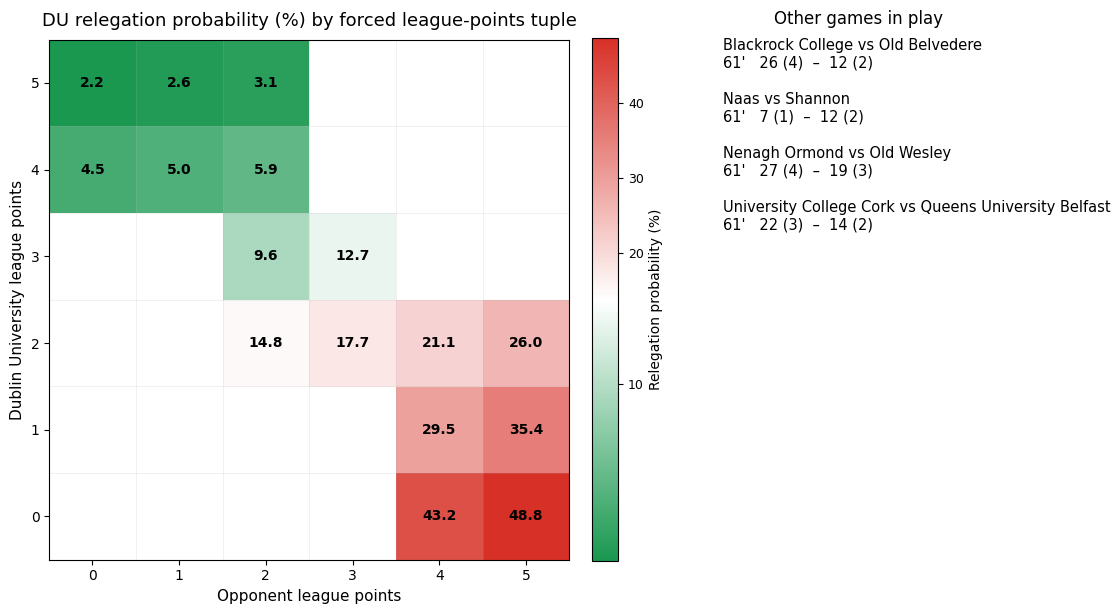

In [41]:
N_SIMS = pts_RD16_future.shape[0]
SEED_INPLAY = 11
SEED_TIES = 123
DU_TEAM = "Dublin University_2425"
OUR_MATCH = ("Dublin University_2425", "Highfield_2425")
END_TIME = 80.0

games = [
    ("Blackrock College RFC_2425", "Old Belvedere_2425"),
    ("Naas_2425", "Shannon_2425"),
    ("Nenagh Ormond_2425", "Old Wesley_2425"),
    ("University College Cork_2425", "Queens University Belfast RFC_2425"),
]


# At 61 mins:
home_scores = [26, 7, 27, 22]
away_scores = [12, 12, 19, 14]

home_tries  = [4, 1, 4, 3]
away_tries  = [2, 2, 3, 2]

game_times = [61.0, 61.0, 61.0, 61.0]
game_LH    = [49.0, 51.0, 58.0, 50.0]

pts_add, diff_add = simulate_inplay_4games_additive(
    games=games,
    home_scores=home_scores, home_tries=home_tries,
    away_scores=away_scores, away_tries=away_tries,
    game_times=game_times,
    game_LH=game_LH,
    params_hat=params_hat,
    team_to_idx=team_to_idx,
    team_season_to_kickrate=team_season_to_kickrate,
    n_sims=N_SIMS,
    seed=SEED_INPLAY,
    end_time=END_TIME,
)

pts_base = pts_RD16_future + pts_add
diff_base = diff_RD16_future + diff_add

# --- evaluate relegation probability for each forced LP tuple on DU fixture ---
res_df = releg_prob_by_lp_tuple(
    teams_sorted=teams_sorted,
    pts_base=pts_base,
    diff_base=diff_base,
    our_match=OUR_MATCH,
    du_team=DU_TEAM,
    allowed_lp_tuples=ALLOWED_LP_TUPLES,
    seed_ties=SEED_TIES,
    p_rel_given_9=0.5,
    p_rel_given_10=1.0,
)
plot_lp_heatmap_pretty(
    res_df,
    games=games,
    home_scores=home_scores, away_scores=away_scores,
    home_tries=home_tries, away_tries=away_tries,
    game_times=game_times,
    baseline_prob=None, 
    title="DU relegation probability (%) by forced league-points tuple",
    home_label="Opponent league points",
    away_label="Dublin University league points",
)

Round 17

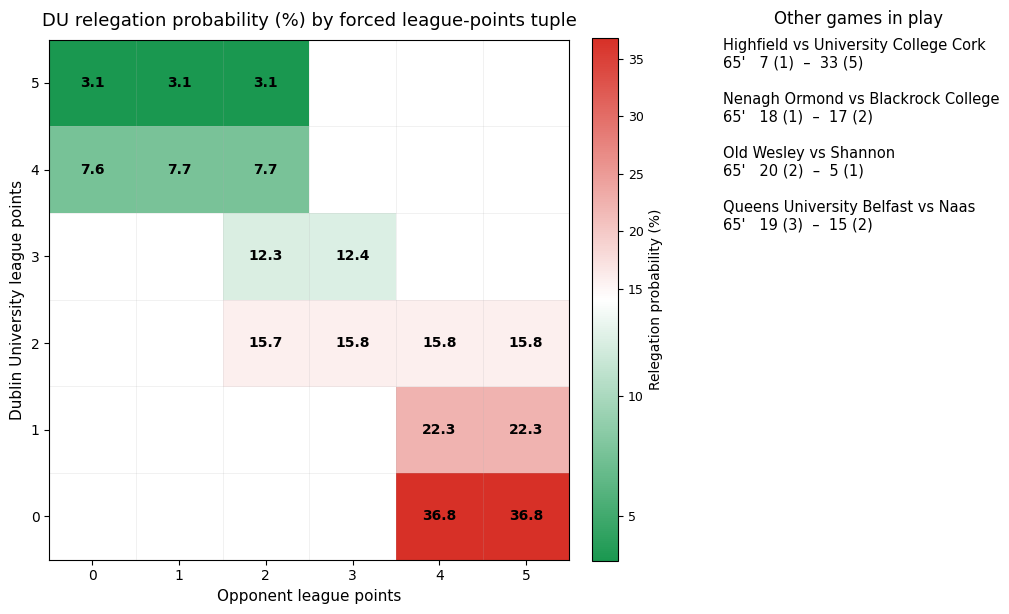

In [42]:
N_SIMS = pts_RD17_future.shape[0]
SEED_INPLAY = 11
SEED_TIES = 123
DU_TEAM = "Dublin University_2425"
OUR_MATCH = ("Old Belvedere_2425", "Dublin University_2425")
END_TIME = 80.0

games = [
    ("Highfield_2425", "University College Cork_2425"),
    ("Nenagh Ormond_2425", "Blackrock College RFC_2425"),
    ("Old Wesley_2425", "Shannon_2425"),
    ("Queens University Belfast RFC_2425", "Naas_2425"),
]

# At 65 mins:
home_scores = [7, 18, 20, 19]
away_scores = [33, 17, 5, 15]

home_tries  = [1, 1, 2, 3]
away_tries  = [5, 2, 1, 2]

game_times = [65.0, 65.0, 65.0, 65.0]
game_LH    = [64.0, 48.0, 52.0, 47.0]

pts_add, diff_add = simulate_inplay_4games_additive(
    games=games,
    home_scores=home_scores, home_tries=home_tries,
    away_scores=away_scores, away_tries=away_tries,
    game_times=game_times,
    game_LH=game_LH,
    params_hat=params_hat,
    team_to_idx=team_to_idx,
    team_season_to_kickrate=team_season_to_kickrate,
    n_sims=N_SIMS,
    seed=SEED_INPLAY,
    end_time=END_TIME,
)

pts_base = pts_RD17_future + pts_add
diff_base = diff_RD17_future + diff_add

# --- evaluate relegation probability for each forced LP tuple on DU fixture ---
res_df = releg_prob_by_lp_tuple(
    teams_sorted=teams_sorted,
    pts_base=pts_base,
    diff_base=diff_base,
    our_match=OUR_MATCH,
    du_team=DU_TEAM,
    allowed_lp_tuples=ALLOWED_LP_TUPLES,
    seed_ties=SEED_TIES,
    p_rel_given_9=0.5,
    p_rel_given_10=1.0,
)

plot_lp_heatmap_pretty(
    res_df,
    games=games,
    home_scores=home_scores, away_scores=away_scores,
    home_tries=home_tries, away_tries=away_tries,
    game_times=game_times,
    baseline_prob=None,
    title="DU relegation probability (%) by forced league-points tuple",
    home_label="Opponent league points",
    away_label="Dublin University league points",
)


Round 18

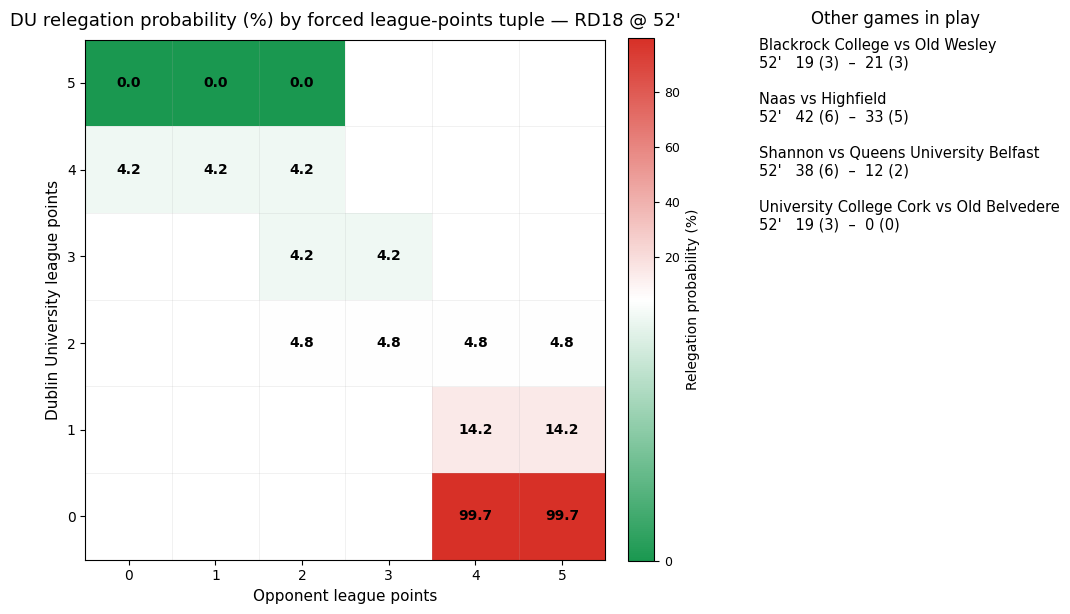

In [43]:
# =========================
# RD18 @ 52 mins (other 4 games in play)
# DU fixture excluded: ("Dublin University_2425", "Nenagh Ormond_2425")
# Base table should be RD17 table only (no RD18 simulated inside pts_RD18_future)
# =========================

N_SIMS = pts_RD18_future.shape[0]
SEED_INPLAY = 11
SEED_TIES = 123
DU_TEAM = "Dublin University_2425"
OUR_MATCH = ("Dublin University_2425", "Nenagh Ormond_2425")
END_TIME = 80.0

games = [
    ("Blackrock College RFC_2425", "Old Wesley_2425"),
    ("Naas_2425", "Highfield_2425"),
    ("Shannon_2425", "Queens University Belfast RFC_2425"),
    ("University College Cork_2425", "Old Belvedere_2425"),
]

# At 52 mins:
home_scores = [19, 42, 38, 19]
away_scores = [21, 33, 12, 0]

home_tries  = [3, 6, 6, 3]
away_tries  = [3, 5, 2, 0]

game_times = [52.0, 52.0, 52.0, 52.0]
game_LH    = [47.0, 50.0, 47.0, 47.0]

# --- IMPORTANT: ensure RD18 "future" base is just the RD17 table repeated ---
# If pts_RD18_future was created via simulate_rest_of_season_excluding_block with RD18 fixtures,
# you MUST replace it with the RD17 table base to avoid double-counting.
pts_RD18_future = np.repeat(
    np.array([league_table_2425_RD17[t]["PTS"] for t in teams_sorted], dtype=np.int32)[None, :],
    N_SIMS,
    axis=0,
)
diff_RD18_future = np.repeat(
    np.array([league_table_2425_RD17[t]["DIFF"] for t in teams_sorted], dtype=np.int32)[None, :],
    N_SIMS,
    axis=0,
)

pts_add, diff_add = simulate_inplay_4games_additive(
    games=games,
    home_scores=home_scores, home_tries=home_tries,
    away_scores=away_scores, away_tries=away_tries,
    game_times=game_times,
    game_LH=game_LH,
    params_hat=params_hat,
    team_to_idx=team_to_idx,
    team_season_to_kickrate=team_season_to_kickrate,
    n_sims=N_SIMS,
    seed=SEED_INPLAY,
    end_time=END_TIME,
)

pts_base = pts_RD18_future + pts_add
diff_base = diff_RD18_future + diff_add

res_df = releg_prob_by_lp_tuple(
    teams_sorted=teams_sorted,
    pts_base=pts_base,
    diff_base=diff_base,
    our_match=OUR_MATCH,
    du_team=DU_TEAM,
    allowed_lp_tuples=ALLOWED_LP_TUPLES,
    seed_ties=SEED_TIES,
    p_rel_given_9=0.5,
    p_rel_given_10=1.0,
)

plot_lp_heatmap_pretty(
    res_df,
    games=games,
    home_scores=home_scores, away_scores=away_scores,
    home_tries=home_tries, away_tries=away_tries,
    game_times=game_times,
    baseline_prob=None,
    title="DU relegation probability (%) by forced league-points tuple — RD18 @ 52'",
    home_label="Opponent league points",
    away_label="Dublin University league points",
)


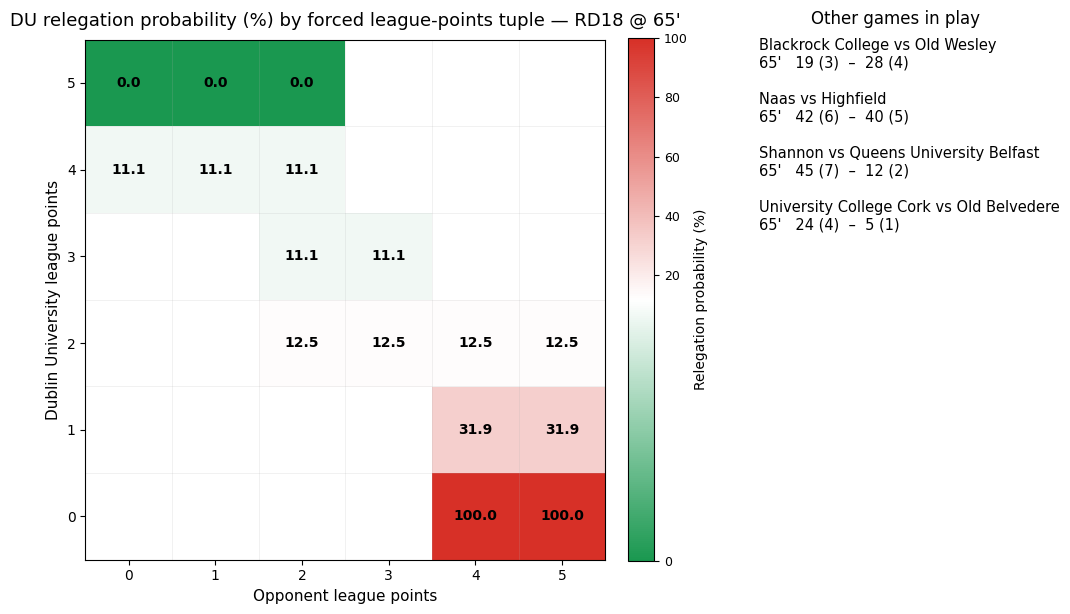

In [44]:
# =========================
# RD18 @ 65 mins (other 4 games in play) — CORRECTED (no double-counting)
# DU fixture excluded: ("Dublin University_2425", "Nenagh Ormond_2425")
# Base table should be RD17 table only (no RD18 simulated inside pts_RD18_future)
# =========================

N_SIMS = pts_RD18_future.shape[0]
SEED_INPLAY = 11
SEED_TIES = 123
DU_TEAM = "Dublin University_2425"
OUR_MATCH = ("Dublin University_2425", "Nenagh Ormond_2425")
END_TIME = 80.0

games = [
    ("Blackrock College RFC_2425", "Old Wesley_2425"),
    ("Naas_2425", "Highfield_2425"),
    ("Shannon_2425", "Queens University Belfast RFC_2425"),
    ("University College Cork_2425", "Old Belvedere_2425"),
]

# At 65 mins:
home_scores = [19, 42, 45, 24]
away_scores = [28, 40, 12, 5]

home_tries  = [3, 6, 7, 4]
away_tries  = [4, 5, 2, 1]

game_times = [65.0, 65.0, 65.0, 65.0]
game_LH    = [62.0, 60.0, 55.0, 62.0]

# --- IMPORTANT: ensure RD18 "future" base is just the RD17 table repeated ---
pts_RD18_future = np.repeat(
    np.array([league_table_2425_RD17[t]["PTS"] for t in teams_sorted], dtype=np.int32)[None, :],
    N_SIMS,
    axis=0,
)
diff_RD18_future = np.repeat(
    np.array([league_table_2425_RD17[t]["DIFF"] for t in teams_sorted], dtype=np.int32)[None, :],
    N_SIMS,
    axis=0,
)

pts_add, diff_add = simulate_inplay_4games_additive(
    games=games,
    home_scores=home_scores, home_tries=home_tries,
    away_scores=away_scores, away_tries=away_tries,
    game_times=game_times,
    game_LH=game_LH,
    params_hat=params_hat,
    team_to_idx=team_to_idx,
    team_season_to_kickrate=team_season_to_kickrate,
    n_sims=N_SIMS,
    seed=SEED_INPLAY,
    end_time=END_TIME,
)

pts_base = pts_RD18_future + pts_add
diff_base = diff_RD18_future + diff_add

res_df = releg_prob_by_lp_tuple(
    teams_sorted=teams_sorted,
    pts_base=pts_base,
    diff_base=diff_base,
    our_match=OUR_MATCH,
    du_team=DU_TEAM,
    allowed_lp_tuples=ALLOWED_LP_TUPLES,
    seed_ties=SEED_TIES,
    p_rel_given_9=0.5,
    p_rel_given_10=1.0,
)

plot_lp_heatmap_pretty(
    res_df,
    games=games,
    home_scores=home_scores, away_scores=away_scores,
    home_tries=home_tries, away_tries=away_tries,
    game_times=game_times,
    baseline_prob=None,
    title="DU relegation probability (%) by forced league-points tuple — RD18 @ 65'",
    home_label="Opponent league points",
    away_label="Dublin University league points",
)
